In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize']=(8,6)
mpl.style.use("seaborn-white")

import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
import os, sys, shutil

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

import pandas as pd
import seaborn as sns

# ephemeral_path = "G:\\ephemeral\\"
# ephemeral_path = "/local/yiming/Desktop/yx6015/ephemeral/"
ephemeral_path = "/rds/general/user/yx6015/ephemeral/"

In [2]:
Fe_aq_names = ['Fe_aq_co2_small_efield_20MVcm', 'Fe_aq_co2_small_efield_30MVcm', 'Fe_aq_co2_small_efield_40MVcm', 'Fe_aq_co2_small_efield_0MVcm']
Fe_aq_out = ['126387.pbs', '126388.pbs', '126389.pbs', '126390.pbs']
dump_period = 100
plt.style.use("seaborn-white")

In [3]:
traj_lists = []
bonds_list = []
connectivity_list = []
log_dfs = []
for name, outdir in zip(Fe_aq_names, Fe_aq_out):
    bonds_list.append(os.path.join(ephemeral_path, outdir, "bonds_atoms.hdf5"))
    connectivity_list.append(os.path.join(ephemeral_path, outdir, "bonds_connectivity.hdf5"))
    traj_lists.append(Trajectory(os.path.join(ephemeral_path, outdir, name+".traj"), 'r'))

In [4]:
log_reader = LAMMPS()
for outdir in Fe_aq_out:
    log_path = os.path.join(ephemeral_path, outdir, "log.lammps")
    log_reader.read_lammps_log(log_path)
    traj_df = pd.DataFrame(log_reader.thermo_content)
    traj_df.set_index('step', inplace=True)
    log_dfs.append(traj_df)

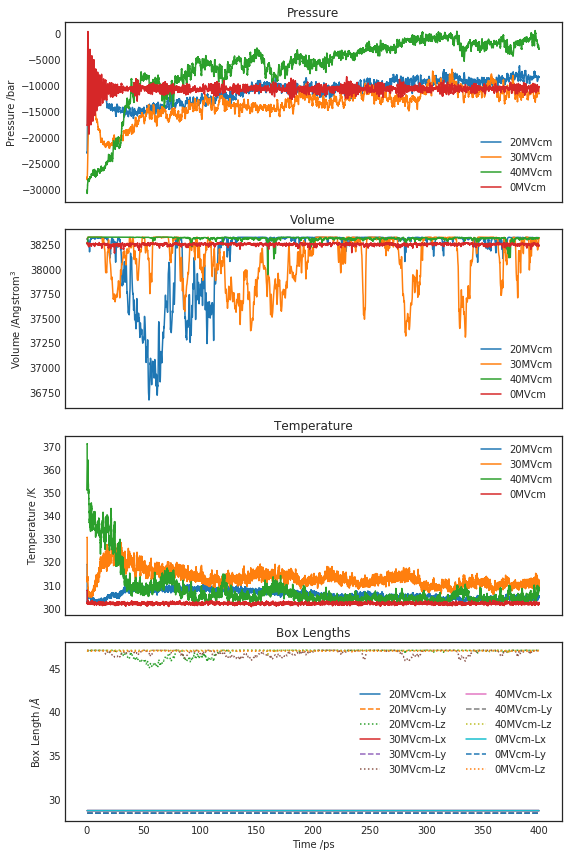

In [5]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(8, 12))
ax1.set_title('Pressure')
ax2.set_title('Volume')
ax3.set_title('Temperature')
ax4.set_title('Box Lengths')

for df, name in zip(log_dfs, [x.split('_')[-1] for x in Fe_aq_names]):
    ax1.plot(df.index/10000, df.press.rolling(5000, center=True).mean(), label = name)
    ax2.plot(df.index/10000, df.vol.rolling(5000, center=True).mean(), label = name)
    ax3.plot(df.index/10000, df.temp.rolling(5000, center=True).mean(), label = name)
    
    ax4.plot(df.index/10000, df.lx.rolling(5000, center=True).mean(), label = name+'-Lx', ls = '-')
    ax4.plot(df.index/10000, df.ly.rolling(5000, center=True).mean(), label = name+'-Ly', ls = '--')
    ax4.plot(df.index/10000, df.lz.rolling(5000, center=True).mean(), label = name+'-Lz', ls = ':')

ax1.set_ylabel("Pressure /bar")
ax2.set_ylabel("Volume /Angstrom$^3$")
ax3.set_ylabel("Temperature /K")
ax4.set_ylabel(r"Box Length /$\AA$")
ax4.set_xlabel("Time /ps")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend(ncol=2)
f.tight_layout()
plt.show()

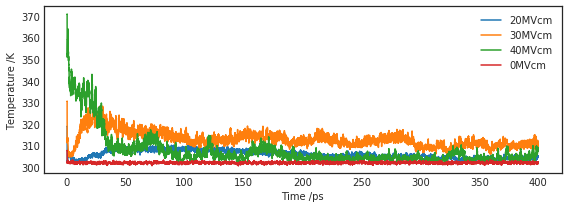

In [6]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))

for df, name in zip(log_dfs, [x.split('_')[-1] for x in Fe_aq_names]):
    ax.plot(df.index/10000, df.temp.rolling(5000, center=True).mean(), label = name)

ax.set_ylabel("Temperature /K")
ax.set_xlabel("Time /ps")

ax.legend()
f.tight_layout()
# f.savefig("fe_aq_co2_small_temp.eps", dpi=400, bbox_inches="tight")
plt.show()

## Collate Prior Data

In [4]:
sim_list = dict()

In [5]:
sim_list['trajectory'] = traj_lists
sim_list['log_df'] = log_dfs
sim_list['names'] = [x.split('_')[-1][:-2]+'/cm' for x in Fe_aq_names]
sim_list['bonds_list'] = bonds_list
sim_list['connectivity_list'] = connectivity_list
sim_list['symbols'] = np.array(traj_lists[0][0].symbols).copy()

## Location of Atoms

In [6]:
steps_to_read = np.arange(len(sim_list['trajectory'][0])-40000, len(sim_list['trajectory'][0]))
step_1 = steps_to_read[0]
steps_to_read

array([    6,     7,     8, ..., 40003, 40004, 40005])

In [7]:
steps_for_tracking = np.arange(step_1, step_1+500)

In [8]:
steps_to_analyse = [steps_to_read[i] for i in [9, 499, 4999, 39999]]
steps_to_analyse

[15, 505, 5005, 40005]

In [9]:
steps_for_kinetics = np.arange(step_1, step_1+100)

In [10]:
Fe_index = np.argwhere(sim_list['symbols']=='Fe').ravel()+1
O_index = np.argwhere(sim_list['symbols']=='O').ravel()+1
C_index = np.argwhere(sim_list['symbols']=='C').ravel()+1

In [11]:
# positions_z = []
# for traj in sim_list['trajectory']:
#     positions_z.append(np.array([traj[t].get_positions().astype(np.float32)[:, 2] for t in steps_to_read]))
# # Savinng binary somewhere
# np.save(file='Fe_aq_co2_small_long_pos_z', arr=positions_z)
# # Loading binary
sim_list['positions_z']=np.load('Fe_aq_co2_small_long_pos_z.npy')
Fe_edge = np.max(sim_list['positions_z'][0,0][sim_list['symbols']=='Fe'])

## Visualization

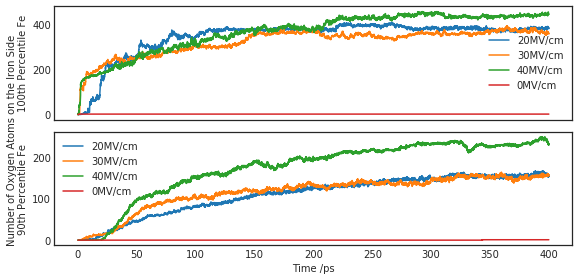

In [13]:
upper_cut_off = 100

f, ax_arr = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax = ax_arr[0]
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read-step_1)*dump_period/10000, O_below_upper, label = name)

ax.set_ylabel("100th Percentile Fe")
# ax.set_xlim(-1, 51)
ax.legend()

ax = ax_arr[1]
upper_cut_off = 90
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read-step_1)*dump_period/10000, O_below_upper, label = name)

ax.set_ylabel("90th Percentile Fe")
ax.set_xlabel("Time /ps")
# ax.set_xlim(-1, 51)
ax.legend()

f.text(0.00, 0.5, 'Number of Oxygen Atoms on the Iron Side', va='center', rotation='vertical')
f.tight_layout()
f.savefig("fe_aq_co2_small_long_oxygen_distribution.eps", dpi=400, bbox_inches="tight")
plt.show()

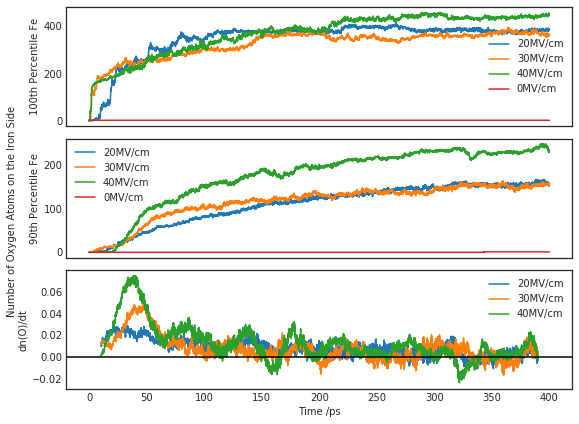

In [13]:
upper_cut_off = 100

f, ax_arr = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax = ax_arr[0]
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read-step_1)*dump_period/10000, O_below_upper, label = name)

ax.set_ylabel("100th Percentile Fe")
# ax.set_xlim(-1, 51)
ax.legend()

ax = ax_arr[1]
upper_cut_off = 90
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read-step_1)*dump_period/10000, O_below_upper, label = name)

ax.set_ylabel("90th Percentile Fe")
# ax.set_xlim(-1, 51)
ax.legend()


ax = ax_arr[2]

for pos_z, name in zip(sim_list['positions_z'][:-1], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read[1000:-1000]-step_1)*dump_period/10000,
            np.gradient(np.cumsum(O_below_upper)[2000:] - np.cumsum(O_below_upper)[:-2000])/1000,
            label = name)

ax.set_ylabel("dn(O)/dt")
ax.set_xlabel("Time /ps")
ax.axhline(0, c='k')
ax.set_yticks([-0.02, 0, 0.02, 0.04, 0.06])
ax.set_ylim(-0.03, 0.08)
ax.legend()

f.text(0.00, 0.5, 'Number of Oxygen Atoms on the Iron Side', va='center', rotation='vertical')
f.tight_layout()
f.savefig("fe_aq_co2_small_long_oxygen_distribution_and_change.eps", dpi=400, bbox_inches="tight")
plt.show()

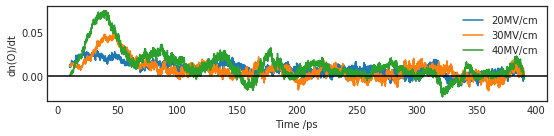

In [16]:
upper_cut_off = 100

f, ax = plt.subplots(1, 1, figsize=(8, 2), sharex=True)

upper_cut_off = 90
for pos_z, name in zip(sim_list['positions_z'][:-1], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read[1000:-1000]-step_1)*dump_period/10000,
            np.gradient(np.cumsum(O_below_upper)[2000:] - np.cumsum(O_below_upper)[:-2000])/1000,
            label = name)

ax.set_ylabel("dn(O)/dt")
ax.set_xlabel("Time /ps")
ax.axhline(0, c='k')
# ax.set_xlim(-1, 51)
ax.legend()

# f.text(0.00, 0.5, 'Number of Oxygen Atoms on the Iron Side', va='center', rotation='vertical')
f.tight_layout()
f.savefig("fe_aq_co2_small_long_oxygen_change_distribution.eps", dpi=400, bbox_inches="tight")
plt.show()

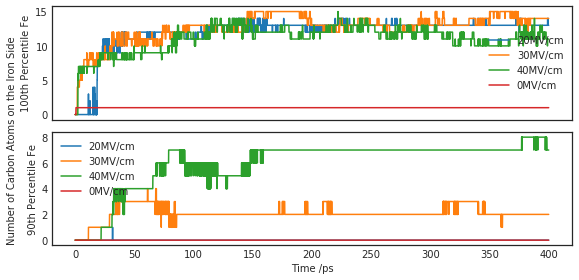

In [45]:
upper_cut_off = 100

f, ax_arr = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax = ax_arr[0]
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    C_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(C_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read-step_1)*dump_period/10000, C_below_upper, label = name)

ax.set_ylabel("100th Percentile Fe")
# ax.set_xlim(-1, 51)
ax.legend()

ax = ax_arr[1]
upper_cut_off = 90
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc= np.percentile(Fe_pos_z, upper_cut_off, axis = 1)
    
    C_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(C_pos_z, Fe_perc)])
    
    ax.plot((steps_to_read-step_1)*dump_period/10000, C_below_upper, label = name)

ax.set_ylabel("90th Percentile Fe")
ax.set_xlabel("Time /ps")
# ax.set_xlim(-1, 51)
ax.legend()

f.text(0.00, 0.5, 'Number of Carbon Atoms on the Iron Side', va='center', rotation='vertical')
f.tight_layout()
# f.savefig("fe_aq_co2_small_carbon_distribution.eps", dpi=400, bbox_inches="tight")
plt.show()

## Distribution Histogram

### For Iron Atoms

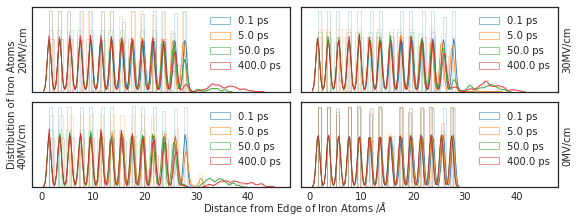

In [14]:
f, ax_arr = plt.subplots(2, 2, figsize=(8, 3), sharex=True)
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr.ravel()):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    
    for s in steps_to_analyse:
        sns.distplot(Fe_pos_z[s-step_1], bins='sqrt',
                     hist_kws={'alpha': 1, "histtype": "step", "linewidth": 0.5},
                     kde_kws={'bw':'0.35', "linewidth": 0.8},
                     ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))
    ax1.set_yticks([], [])
    ax1.set_ylabel(name)
    ax1.legend()
    if name.startswith('0') or name.startswith('3'):
        ax1.yaxis.set_label_position("right")
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = []
    for i in handles:
        i.set_alpha(0.4)
    
f.text(0.00, 0.5, 'Distribution of Iron Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Distance from Edge of Iron Atoms /$\AA$', ha='center')

f.tight_layout()
f.savefig("fe_aq_co2_small_long_iron_histogram.pdf", dpi=400, bbox_inches="tight")
plt.show()

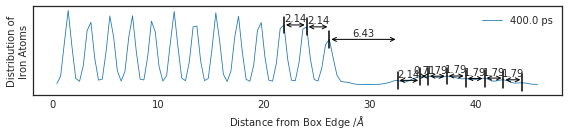

In [18]:
from scipy.signal import find_peaks
f, ax1 = plt.subplots(1, 1, figsize=(8, 2), sharex=True)
for pos_z, name in zip(sim_list['positions_z'][2:3], sim_list['names'][2:3]):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    
    s = steps_to_analyse[-1]
    sns.kdeplot(Fe_pos_z[s-step_1], bw=0.35, linewidth=0.8, ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))
    
    ax1.set_yticks([], [])
    ax1.set_ylabel('Distribution of\nIron Atoms')
    ax1.set_xlabel('Distance from Box Edge /$\AA$')
    
plt_x = ax1.lines[0].get_xdata()
plt_y = ax1.lines[0].get_ydata()

peak_cut_off = 21
x_peaks = find_peaks(plt_y[plt_x>peak_cut_off])
x_coord = np.array([plt_x[plt_x>peak_cut_off][i] for i in x_peaks[0]])
y_coord = np.array([plt_y[plt_x>peak_cut_off][i] for i in x_peaks[0]])
x_diff = x_coord[1:] - x_coord[:-1]

for i, (xc, yc) in enumerate(zip(x_coord, y_coord)):
    ax1.plot([xc, xc], [yc-0.01, yc+0.01], c='k')
    if i < len(x_coord) - 1:
        ax1.annotate("", xy=(xc, yc), xytext=(x_coord[i+1], yc), arrowprops=dict(arrowstyle="<->"))
        ax1.text(xc+x_diff[i]/2, yc+0.004, "{:.2f}".format(x_diff[i]), ha = 'center')
        
f.tight_layout()
# f.savefig("fe_aq_small_iron_40mvcm_kde_peaks.eps", dpi=400, bbox_inches="tight")
plt.show()

### For Oxygen Atoms

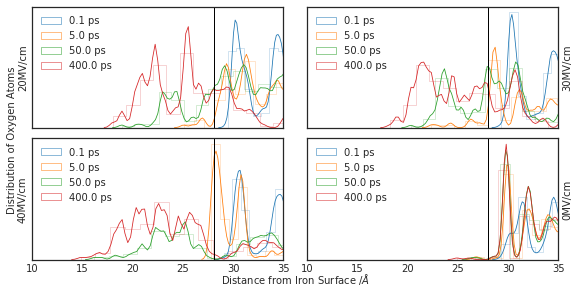

In [39]:
f, ax_arr = plt.subplots(2, 2, figsize=(8, 4), sharex=True)

for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr.ravel()):
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
#     O_delta = np.array([i-j for i, j in zip(O_pos_z, Fe_lower)])
    
    for s in steps_to_analyse:
        sns.distplot(O_pos_z[s-step_1], bins='sqrt',
                     hist_kws={'alpha': 1, "histtype": "step", "linewidth": 0.5},
                     kde_kws={'bw':'0.3', "linewidth": 0.8},
                     ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))

    ax1.set_xlim(10, 35)
    ax1.set_yticks([], [])
    ax1.set_ylabel(name)
    ax1.axvline(Fe_edge, linewidth=1, c = 'k')
    ax1.legend()
    if name.startswith('0') or name.startswith('3'):
        ax1.yaxis.set_label_position("right")
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = []
    for i in handles:
        i.set_alpha(0.4)
        
f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Distance from Iron Surface /$\AA$', ha='center')
    
f.tight_layout()
f.savefig("fe_aq_co2_small_long_oxygen_histogram.pdf", dpi=400, bbox_inches="tight")
plt.show()

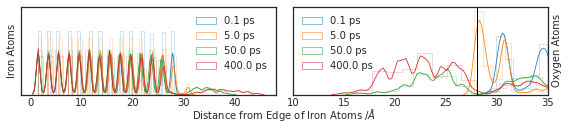

In [20]:
f, ax_arr = plt.subplots(1, 2, figsize=(8, 1.7), sharey=True)
for pos_z, name in zip(sim_list['positions_z'][2:3], sim_list['names'][2:3]):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    ax1 = ax_arr[0]
    for s in steps_to_analyse:
        sns.distplot(Fe_pos_z[s-step_1], bins='sqrt',
                     hist_kws={'alpha': 1, "histtype": "step", "linewidth": 0.5},
                     kde_kws={'bw':'0.35', "linewidth": 0.8},
                     ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))
    ax1.set_yticks([], [])
    ax1.set_ylabel('Iron Atoms')
    ax1.legend()
    if name.startswith('0') or name.startswith('3'):
        ax1.yaxis.set_label_position("right")
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = []
    for i in handles:
        i.set_alpha(0.4)
    
    ax1 = ax_arr[1]
    for s in steps_to_analyse:
        sns.distplot(O_pos_z[s-step_1], bins='sqrt',
                     hist_kws={'alpha': 1, "histtype": "step", "linewidth": 0.5},
                     kde_kws={'bw':'0.35', "linewidth": 0.8},
                     ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))

    ax1.set_xlim(10, 35)
    ax1.set_yticks([], [])
    ax1.set_ylabel("Oxygen Atoms")
    ax1.yaxis.set_label_position("right")
    ax1.axvline(Fe_edge, linewidth=1, c = 'k')
    ax1.legend()
    if name.startswith('0') or name.startswith('3'):
        ax1.yaxis.set_label_position("right")
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = []
    for i in handles:
        i.set_alpha(0.4)
        
f.text(0.5, 0.00, 'Distance from Edge of Iron Atoms /$\AA$', ha='center')
    
f.tight_layout()
# f.savefig("fe_aq_co2_small_fe_o_histogram.pdf", dpi=400, bbox_inches="tight")
plt.show()

### For Carbon Atoms

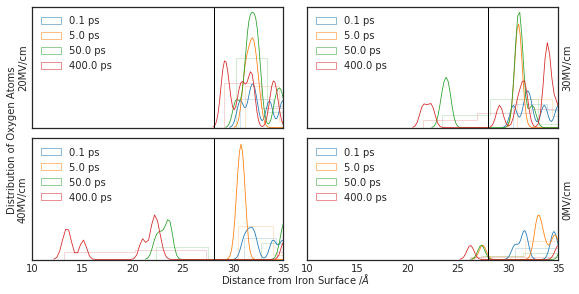

In [21]:
f, ax_arr = plt.subplots(2, 2, figsize=(8, 4), sharex=True)

for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr.ravel()):
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
#     C_delta = np.array([i-j for i, j in zip(C_pos_z, Fe_lower)])
    
    for s in steps_to_analyse:
        sns.distplot(C_pos_z[s-step_1], bins='sqrt',
                     hist_kws={'alpha': 1, "histtype": "step", "linewidth": 0.5},
                     kde_kws={'bw':'0.35', "linewidth": 0.8},
                     ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))

    ax1.set_xlim(10, 35)
    ax1.set_yticks([], [])
    ax1.set_ylabel(name)
    ax1.axvline(Fe_edge, linewidth=1, c = 'k')
    ax1.legend()
    if name.startswith('0') or name.startswith('3'):
        ax1.yaxis.set_label_position("right")
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = []
    for i in handles:
        i.set_alpha(0.4)
        
f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Distance from Iron Surface /$\AA$', ha='center')
    
f.tight_layout()
# f.savefig("fe_aq_co2_small_carbon_histogram.pdf", dpi=400, bbox_inches="tight")
plt.show()

## Charge of Various Species

In [22]:
from ase.visualize.plot import plot_atoms
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu,
                           norm=mpl.colors.Normalize(vmin=-1., vmax=1.0))
sm.set_array([])

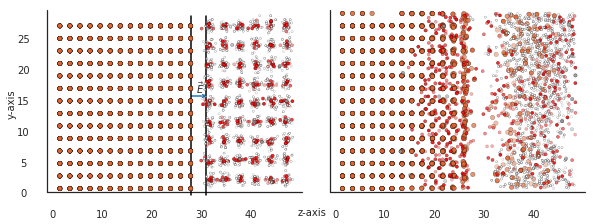

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
from ase.data.colors import cpk_colors, jmol_colors
plt.style.use('seaborn-white')

f = plt.figure(figsize=(8, 3))
# f.subplots_adjust(left=0, right=1, bottom=0, top=1)
traj = sim_list['trajectory'][2]
name = sim_list['names'][2]

ax = f.add_subplot(1, 2, 1, projection='3d', proj_type = 'ortho')

atoms_to_plot =  traj[0]
pos = atoms_to_plot.get_positions()
a_num = atoms_to_plot.get_atomic_numbers()
sizes = covalent_radii[a_num]*15
colors = jmol_colors[a_num]

ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
           s=sizes,
           c=colors,
           edgecolor='black',
           linewidths=0.3)
#     ax.set_title(name)
#     ax.set_xlabel('x')

ax.grid(False)

ax.quiver(0,Fe_edge,15,0,3,0)
ax.text(0,Fe_edge+0.9,15.5, r'$\vec{E}$')
ax.plot([0, 0], [Fe_edge, Fe_edge], [-1, Fe_edge], c = 'k')
ax.plot([0, 0], [Fe_edge+3, Fe_edge+3], [-1, Fe_edge], c = 'k')

ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.set_xlim3d(0, ax_limits[0])
ax.set_ylim3d(0, ax_limits[2])
ax.set_zlim3d(0, ax_limits[1])
ax.set_xticks([])
ax.view_init(elev=0, azim=0)
ax.dist = 6


ax = f.add_subplot(1, 2, 2, projection='3d', proj_type = 'ortho')

atoms_to_plot =  traj[-1]
pos = atoms_to_plot.get_positions()
a_num = atoms_to_plot.get_atomic_numbers()
sizes = covalent_radii[a_num]*15
colors = jmol_colors[a_num]

ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
           s=sizes,
           c=colors,
           edgecolor='black',
           linewidths=0.3)
#     ax.set_title(name)
#     ax.set_xlabel('x')

ax.grid(False)

ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.set_xlim3d(0, ax_limits[0])
ax.set_ylim3d(0, ax_limits[2])
ax.set_zlim3d(0, ax_limits[1])
ax.set_xticks([])
ax.view_init(elev=0, azim=0)
ax.dist = 6
ax.set_zticks([])

f.text(-0.03, 0.5, 'y-axis', va='center', rotation='vertical')
f.text(0.5, -0.015, 'z-axis', ha='center')
f.tight_layout()

# f.savefig('fe_aq_co2_small_first_last_{}.png'.format(name.replace('/','')), dpi=400, bbox_inches="tight")
plt.show()

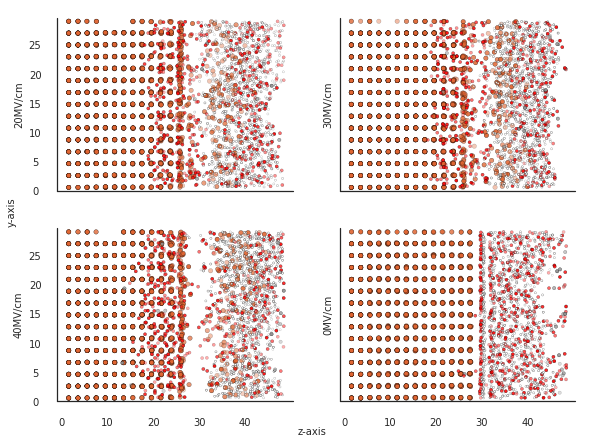

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
from ase.data.colors import jmol_colors
plt.style.use('seaborn-white')

f = plt.figure(figsize=(8, 6))
# f.subplots_adjust(left=0, right=1, bottom=0, top=1)
for i, (traj, name) in enumerate(zip(sim_list['trajectory'], sim_list['names'])):

    ax = f.add_subplot(2, 2, i+1, projection='3d', proj_type = 'ortho')

    atoms_to_plot =  traj[-1]
    pos = atoms_to_plot.get_positions()
    a_num = atoms_to_plot.get_atomic_numbers()
    sizes = covalent_radii[a_num]*15
    colors = jmol_colors[a_num]

    ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

    ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
               s=sizes,
               c=colors,
               edgecolor='black',
               linewidths=0.3)
#     ax.set_title(name)
#     ax.set_xlabel('x')
    
    ax.grid(False)

    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.set_xlim3d(0, ax_limits[0])
    ax.set_ylim3d(0, ax_limits[2])
    ax.set_zlim3d(0, ax_limits[1])
    ax.set_xticks([])
    ax.view_init(elev=0, azim=0)
    ax.dist = 6.5
    
    if name.startswith('0'):
        ax.set_zticks([])
        ax.set_zlabel(name, labelpad=-15)
    elif name.startswith('4'):
        ax.set_zlabel(name, labelpad=-1)
    elif name.startswith('2'):
        ax.set_yticks([])
        ax.set_zlabel(name, labelpad=-1)
    elif name.startswith('3'):
        ax.set_zlabel(name, labelpad=-15)
        ax.set_zticks([])
        ax.set_yticks([])

        
f.text(-0.03, 0.5, 'y-axis', va='center', rotation='vertical')
f.text(0.5, -0.015, 'z-axis', ha='center')
f.tight_layout()

# f.savefig('fe_aq_co2_small_last.png'.format(name), dpi=400, bbox_inches="tight")
plt.show()

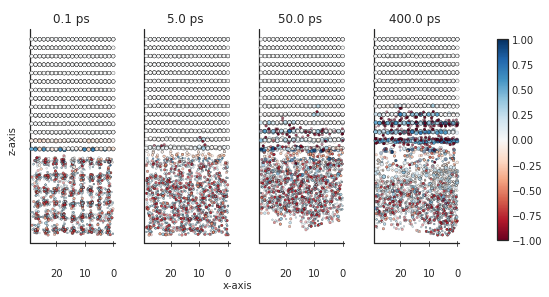

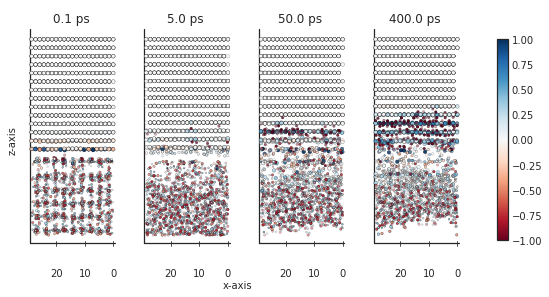

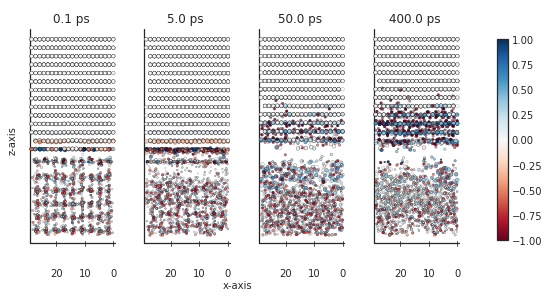

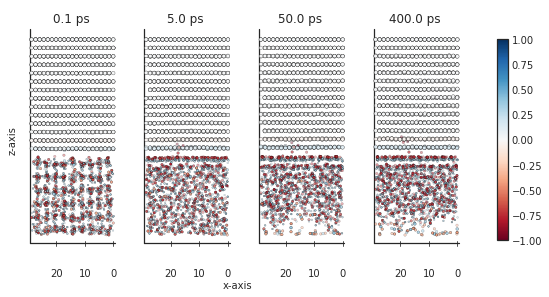

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
plt.style.use('seaborn-white')

for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f = plt.figure(figsize=(8, 4))
    
    for i, s in enumerate(steps_to_analyse):
        ax = f.add_subplot(1, 4, i+1, projection='3d', proj_type = 'ortho')
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(s-step_1))
        
        atoms_to_plot =  traj[s]
        pos = atoms_to_plot.get_positions()
        a_num = atoms_to_plot.get_atomic_numbers()
        sizes = covalent_radii[a_num]*10
        colors = sm.to_rgba(atom_df.charge)
        
        ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

        ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
                   s=sizes,
                   c=colors,
                   edgecolor='black',
                   linewidths=0.3)
        ax.set_title('{:.1f} ps'.format((s-step_1)*dump_period/10000), ha='center')
        ax.grid(False)

        ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.set_xlim3d(0, ax_limits[0])
        ax.set_ylim3d(0, ax_limits[2])
        ax.set_zlim3d(0, ax_limits[1])
        ax.set_zticks([])
        ax.view_init(elev=90, azim=90)
        ax.dist = 7
        if s != 30:
            ax.set_yticks([])
        
#     f.suptitle(name)
    f.text(0, 0.5, 'z-axis', va='center', rotation='vertical')
    f.text(0.4, -0.015, 'x-axis', ha='center')
    
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
#     f.savefig('fe_aq_co2_small_charge_{}.png'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
    
plt.show()

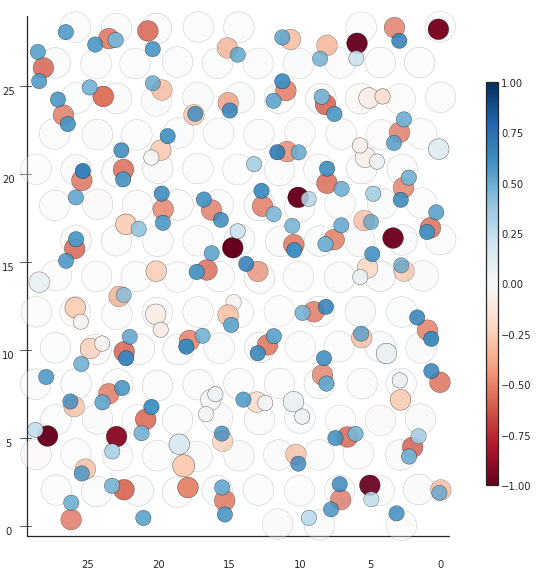

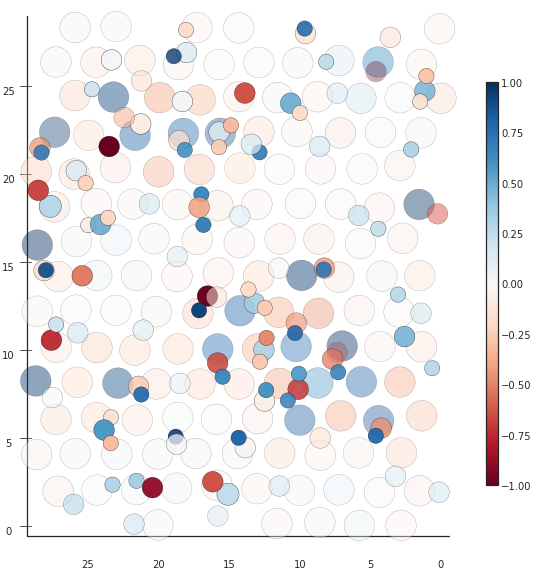

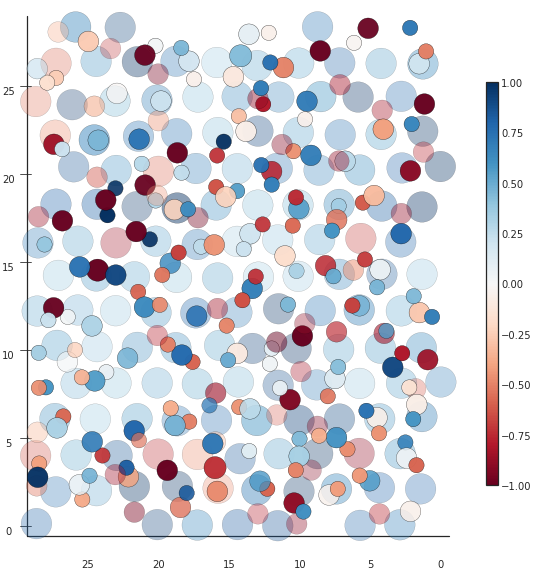

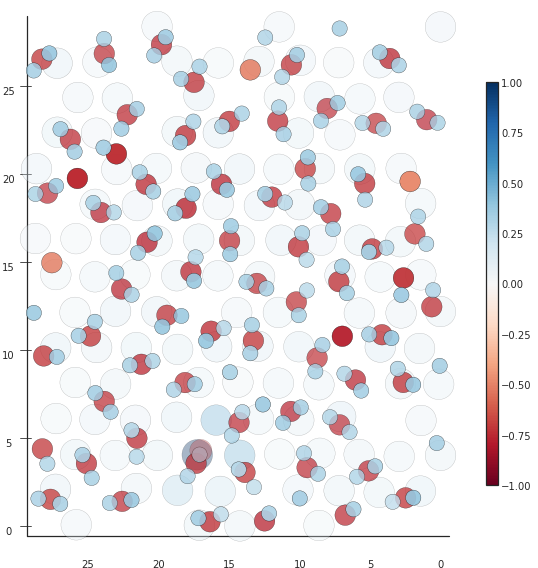

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
plt.style.use('seaborn-white')

for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f = plt.figure(figsize=(8, 8))
    
    s = 106
    ax = f.add_subplot(1, 1, 1, projection='3d', proj_type = 'ortho')
#         ax = f.add_subplot(1, 1, i+1, projection='3d')
    atom_df = pd.read_hdf(bl, key = 'step{}'.format(s-step_1))

    atoms_to_plot =  traj[s]
    pos = atoms_to_plot.get_positions()
    selection = np.logical_and(pos[:, 2] > 27, pos[:, 2] < 31) # thin layer at interface

    atoms_to_plot = atoms_to_plot[selection]
    pos = atoms_to_plot.get_positions()
    a_num = atoms_to_plot.get_atomic_numbers()
    sizes = 230*(covalent_radii[a_num]+0.7)**2
    colors = sm.to_rgba(atom_df.charge)[selection]
    

    ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

    ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
               s=sizes,
               c=colors,
               edgecolor='black',
               linewidths=0.3)
#         ax.set_title('{:.1f} ps'.format((s-30)*dump_period/10000), ha='center')
    ax.grid(False)

    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.set_xlim3d(0, ax_limits[0])
    ax.set_ylim3d(0, ax_limits[2])
    ax.set_zlim3d(0, ax_limits[1])
#         ax.set_zticks([])
    ax.view_init(elev=0, azim=90)
    ax.dist = 6
    ax.set_yticks([])

    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
#     f.savefig('fe_aq_co2_small_charge_interface_1fs_{}.pdf'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
    
plt.show()

### Final Frame

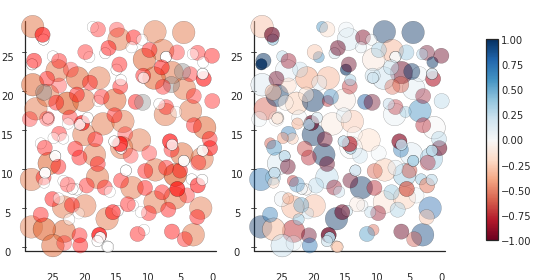

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
from ase.data.colors import jmol_colors

plt.style.use('seaborn-white')

for traj, name, bl in zip(sim_list['trajectory'][2:3], sim_list['names'][2:3], sim_list['bonds_list'][2:3]):
    f = plt.figure(figsize=(8, 4))
    
    s = 1005
    
#         ax = f.add_subplot(1, 1, i+1, projection='3d')
    atom_df = pd.read_hdf(bl, key = 'step{}'.format(s-step_1))

    atoms_to_plot =  traj[s]
    pos = atoms_to_plot.get_positions()
    selection = np.logical_and(pos[:, 2] > 30, pos[:, 2] < 34) # thin layer at interface

    atoms_to_plot = atoms_to_plot[selection]
    pos = atoms_to_plot.get_positions()
    a_num = atoms_to_plot.get_atomic_numbers()
    sizes = 125*(covalent_radii[a_num]+0.7)**2
    
    ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]
    
    ax = f.add_subplot(1, 2, 1, projection='3d', proj_type = 'ortho')
    colors = jmol_colors[a_num]
    ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
               s=sizes,
               c=colors,
               edgecolor='black',
               linewidths=0.3)
#         ax.set_title('{:.1f} ps'.format((s-30)*dump_period/10000), ha='center')
    ax.grid(False)

    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.set_xlim3d(0, ax_limits[0])
    ax.set_ylim3d(0, ax_limits[2])
    ax.set_zlim3d(0, ax_limits[1])
#         ax.set_zticks([])
    ax.view_init(elev=0, azim=90)
    ax.dist = 6.5
    ax.set_yticks([])

    # Plot 2
    
    ax = f.add_subplot(1, 2, 2, projection='3d', proj_type = 'ortho')
    colors = sm.to_rgba(atom_df.charge)[selection]
    ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
               s=sizes,
               c=colors,
               edgecolor='black',
               linewidths=0.3)
#         ax.set_title('{:.1f} ps'.format((s-30)*dump_period/10000), ha='center')
    ax.grid(False)

    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.set_xlim3d(0, ax_limits[0])
    ax.set_ylim3d(0, ax_limits[2])
    ax.set_zlim3d(0, ax_limits[1])
#         ax.set_zticks([])
    ax.view_init(elev=0, azim=90)
    ax.dist = 6.5
    ax.set_yticks([])
    
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
#     f.savefig('fe_aq_co2_small_charge_interface_1fs_{}.pdf'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
    
plt.show()

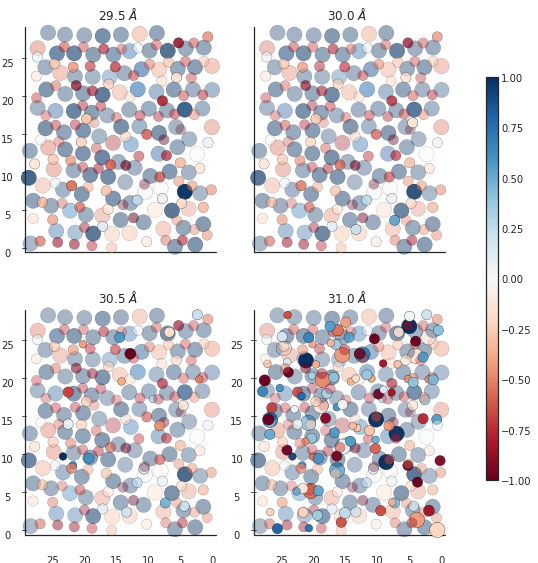

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
plt.style.use('seaborn-white')

for traj, name, bl in zip(sim_list['trajectory'][2:3], sim_list['names'][2:3], sim_list['bonds_list'][2:3]):
    f = plt.figure(figsize=(8, 8))
    
    s = 556
    atom_df = pd.read_hdf(bl, key = 'step{}'.format(s-step_1))
    for i in range(4):

        ax = f.add_subplot(2, 2, i+1, projection='3d', proj_type = 'ortho')
    #         ax = f.add_subplot(1, 1, i+1, projection='3d')
        
        atoms_to_plot =  traj[s]
        pos = atoms_to_plot.get_positions()
        selection = np.logical_and(pos[:, 2] > 27, pos[:, 2] < 29.5+0.5*i) # thin layer at interface

        atoms_to_plot = atoms_to_plot[selection]
        pos = atoms_to_plot.get_positions()
        a_num = atoms_to_plot.get_atomic_numbers()
        sizes = 57.5*(covalent_radii[a_num]+0.7)**2
        colors = sm.to_rgba(atom_df.charge)[selection]

        ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

        ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
                   s=sizes,
                   c=colors,
                   edgecolor='black',
                   linewidths=0.3)
    #         ax.set_title('{:.1f} ps'.format((s-30)*dump_period/10000), ha='center')
        ax.grid(False)

        ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
        ax.set_xlim3d(0, ax_limits[0])
        ax.set_ylim3d(0, ax_limits[2])
        ax.set_zlim3d(0, ax_limits[1])
        
        ax.view_init(elev=0, azim=90)
        ax.dist = 6.5
        ax.set_yticks([])
        ax.set_title('{:.1f} $\AA$'.format(29.5+0.5*i), pad=15)
        if i == 4 or i == 1:
            ax.set_zticks([])
        if i == 0 or i == 1:
            ax.set_xticks([])
    
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
#     f.savefig('fe_aq_co2_small_charege_interface_5.5fs_cutoff_{}.pdf'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
    
plt.show()

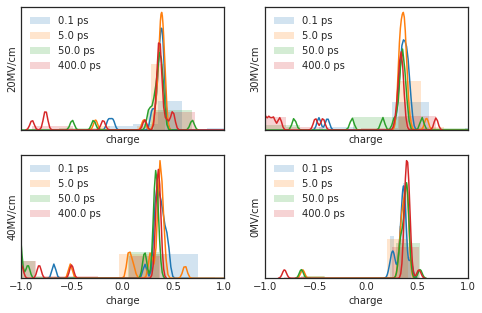

In [29]:
f, ax_arr = plt.subplots(2, 2, figsize=(8, 5), sharex=True)

for bl, name, ax1 in zip(sim_list['bonds_list'], sim_list['names'], ax_arr.ravel()):
    for s in steps_to_analyse:
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(s-step_1))
        fe_df = atom_df[atom_df.atom_type==1]
        fe_charges = fe_df.charge
        sns.distplot(fe_charges, bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.02'}, ax=ax1, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))

    ax1.set_xlim(-1, 1)
    ax1.set_ylabel(name)
    ax1.set_yticks([], [])
    ax1.legend()
    
# f.text(0.5, 0.00, 'Distance from Box Edge /$\AA$', ha='center')
    
# f.tight_layout()
# f.savefig("fe_aq_small_iron_histogram.eps", dpi=400)
plt.show()

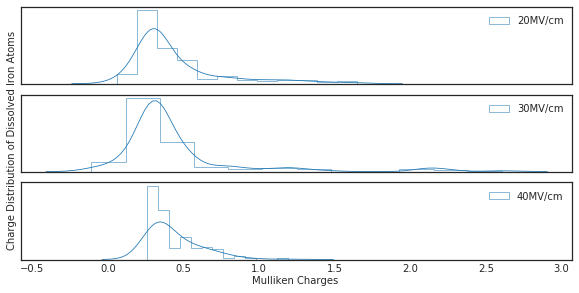

In [15]:
f, ax_arr = plt.subplots(3, 1, figsize=(8, 4), sharex=True)

for bl, name, pos_z, ax1 in zip(sim_list['bonds_list'], sim_list['names'], sim_list['positions_z'], ax_arr.ravel()):
    s = steps_to_read[-1]
    atom_df = pd.read_hdf(bl, key = 'step{}'.format(s-step_1))

    dissolved_fe_df = atom_df.iloc[np.logical_and(pos_z[np.where(steps_to_read==s)[0][0]] > Fe_edge, sim_list['symbols'] == 'Fe')]
    dissolved_fe_charges = dissolved_fe_df.charge
    sns.distplot(dissolved_fe_charges, bins='sqrt',
                 hist_kws={'alpha': 1, "histtype": "step", "linewidth": 0.5},
                 kde_kws={'bw':'0.1', "linewidth": 0.8}, ax=ax1, label=name)

#     ax1.set_xlim(-1, 1)
    ax1.set_xlabel(None)
    ax1.set_yticks([], [])
    ax1.legend()
    
f.text(0.5, 0.00, 'Mulliken Charges', ha='center')
f.text(0.00, 0.5, 'Charge Distribution of Dissolved Iron Atoms', va='center', rotation='vertical')

f.tight_layout()
# f.savefig("fe_aq_small_dissolved_iron_charges_last_histogram.pdf", dpi=400)
plt.show()

## Iron RDF

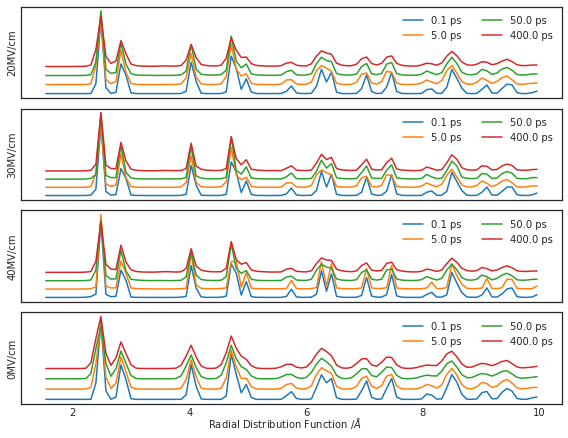

In [31]:
from ase.neighborlist import neighbor_list
f, ax_arr = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

for traj, name, ax in zip(sim_list['trajectory'], sim_list['names'], ax_arr):
    for i, step in enumerate(steps_to_analyse):
        fe_only = traj[step][sim_list['symbols'] == 'Fe']
        d = neighbor_list('d', fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=np.linspace(1.5, 10.00, 100))
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * fe_only.get_volume()/len(fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf+i*4196, label = '{:.1f} ps'.format((step-step_1)*dump_period/10000))
        
    ax.legend(ncol=2)
    ax.set_yticks([], [])
    ax.set_ylabel(name)

# f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Radial Distribution Function /$\AA$', ha='center')
f.tight_layout()
# f.savefig('fe_aq_small_fe_rdf.eps', dpi=400, bbox_inches="tight")
plt.show()

/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


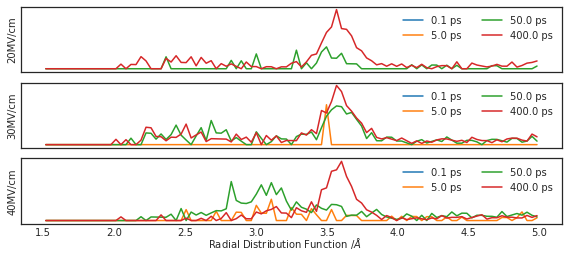

In [32]:
from ase.neighborlist import neighbor_list
f, ax_arr = plt.subplots(3, 1, figsize=(8, 3.5), sharex=True)

for traj, name, ax in zip(sim_list['trajectory'][:-1], sim_list['names'], ax_arr):
    for i, step in enumerate(steps_to_analyse):
        fe_only = traj[step][sim_list['symbols'] == 'Fe']
        dissolved_fe_only = fe_only[fe_only.get_positions()[:,2] > Fe_edge+0.5]
        d = neighbor_list('d', dissolved_fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=np.linspace(1.5, 5.00, 100))
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * dissolved_fe_only.get_volume()/len(dissolved_fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf, label = '{:.1f} ps'.format((step-step_1)*dump_period/10000))
    ax.legend(ncol=2)
    ax.set_yticks([])
    ax.set_ylabel(name)


# f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Radial Distribution Function /$\AA$', ha='center')
f.tight_layout()
# f.savefig('fe_aq_small_dissolved_fe_rdf.eps', dpi=400, bbox_inches="tight")
plt.show()

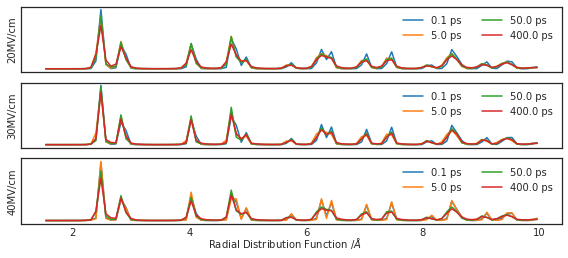

In [19]:
from ase.neighborlist import neighbor_list
f, ax_arr = plt.subplots(3, 1, figsize=(8, 3.5), sharex=True)

for traj, name, ax in zip(sim_list['trajectory'][:-1], sim_list['names'], ax_arr):
    for i, step in enumerate(steps_to_analyse):
        step = steps_to_read[-1]
        fe_only = traj[step][sim_list['symbols'] == 'Fe']
        dissolved_fe_only = fe_only[fe_only.get_positions()[:,2] <= Fe_edge]
        d = neighbor_list('d', dissolved_fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=np.linspace(1.5, 10.00, 100))
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * dissolved_fe_only.get_volume()/len(dissolved_fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2

        ax.plot(x_axis, pdf+i*4196, label = '{:.1f} ps'.format((step-step_1)*dump_period/10000))
    ax.legend(ncol=2)
    ax.set_yticks([])
    ax.set_ylabel(name)


# f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Radial Distribution Function /$\AA$', ha='center')
f.tight_layout()
# f.savefig('fe_aq_small_dissolved_fe_rdf.eps', dpi=400, bbox_inches="tight")
plt.show()

## Oxygen RDF

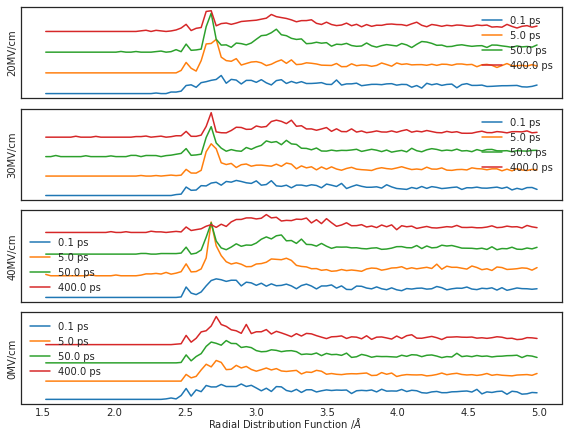

In [33]:
from ase.neighborlist import neighbor_list
f, ax_arr = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

for traj, name, ax in zip(sim_list['trajectory'], sim_list['names'], ax_arr):
    for i, step in enumerate(steps_to_analyse):
        o_only = traj[step][sim_list['symbols'] == 'O']
        d = neighbor_list('d', o_only, 10.00)
        h, bin_edges = np.histogram(d, bins=np.linspace(1.5, 5.00, 100))
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * o_only.get_volume()/len(o_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf+i*2500, label = '{:.1f} ps'.format((step-step_1)*dump_period/10000))
        ax.legend()
        ax.set_yticks([])
        ax.set_ylabel(name)


# f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Radial Distribution Function /$\AA$', ha='center')
f.tight_layout()
# f.savefig('fe_aq_co2_small_o_rdf.eps'.format(name), dpi=400, bbox_inches="tight")
plt.show()

/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


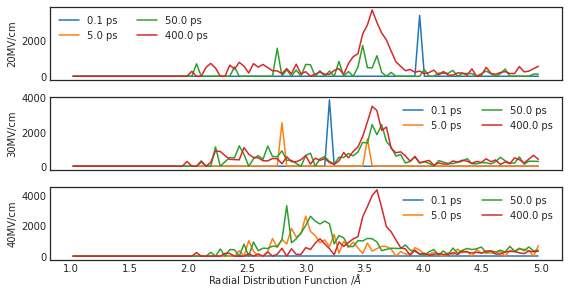

In [34]:
from ase.neighborlist import neighbor_list
f, ax_arr = plt.subplots(3, 1, figsize=(8, 4), sharex=True)

for traj, name, ax in zip(sim_list['trajectory'][:-1], sim_list['names'], ax_arr):
    for i, step in enumerate(steps_to_analyse):
        fe_only = traj[step][sim_list['symbols'] == 'Fe']
        dissolved_fe_only = fe_only[fe_only.get_positions()[:,2] > Fe_edge]
        d = neighbor_list('d', dissolved_fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=np.linspace(1, 5.00, 100))
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * dissolved_fe_only.get_volume()/len(dissolved_fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf, label = '{:.1f} ps'.format((step-step_1)*dump_period/10000))
    ax.legend(ncol=2)
#     ax.set_yticks([])
    ax.set_ylabel(name)


# f.text(0.00, 0.5, 'Distribution of Oxygen Atoms', va='center', rotation='vertical')
f.text(0.5, 0.00, 'Radial Distribution Function /$\AA$', ha='center')
f.tight_layout()
# f.savefig('fe_aq_small_dissolved_fe_rdf.eps', dpi=400, bbox_inches="tight")
plt.show()

## Coordination

### Iron

/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/rds/general/user/yx6015/home/anaconda3/lib/python3.7/site-packages/matplotl

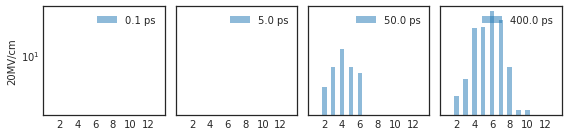

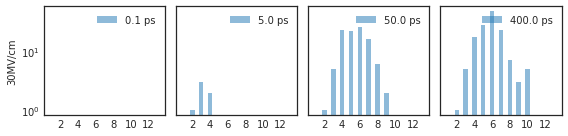

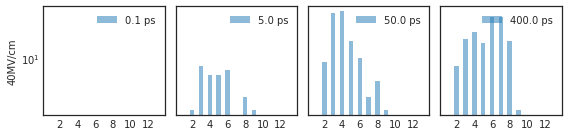

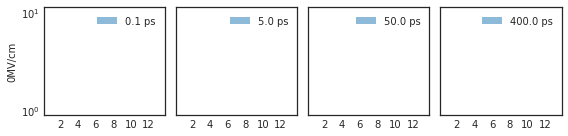

In [25]:
for cl, name, pos_z in zip(sim_list['connectivity_list'], sim_list['names'], sim_list['positions_z']):
    f, ax_arr = plt.subplots(1, 4, figsize=(8, 2), sharey=True)

    for s, ax in zip(steps_to_analyse, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(s - step_1))
        dissolved_fe = Fe_index[pos_z[s-step_1][Fe_index-1] > Fe_edge+0.5]
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in dissolved_fe])
        
        sns.distplot(coordination, kde=False,
                     bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5],
                     hist_kws={'alpha': 0.5, 'align': 'mid', 'rwidth': 0.5},
                     ax=ax, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))
        ax.legend()
    
        ax.set_xticks([2, 4, 6, 8, 10, 12])
        ax.set_yscale('log')
    ax_arr[0].set_ylabel("{}".format(name))
    f.tight_layout()
#     f.savefig('fe_aq_small_fe_coordination_{}.eps'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
plt.show()

### Oxygen

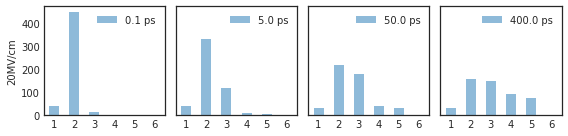

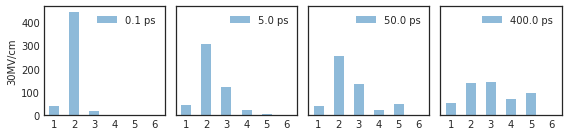

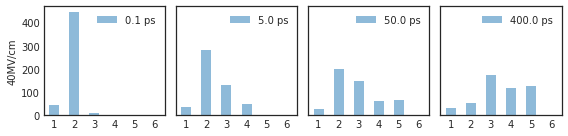

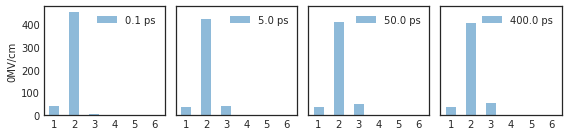

In [36]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 4, figsize=(8, 2), sharey=True)

    for s, ax in zip(steps_to_analyse, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(s - step_1))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in O_index])
        
        sns.distplot(coordination, kde=False,
                     bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
                     hist_kws={'alpha': 0.5, 'align': 'mid', 'rwidth': 0.5},
                     ax=ax, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))
        ax.legend()
    
        ax.set_xticks(range(1, 7))
#         ax.set_yscale('log')
    ax_arr[0].set_ylabel("{}".format(name))
    f.tight_layout()
#     f.savefig('fe_aq_small_fe_coordination_{}.eps'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
plt.show()

### Carbon

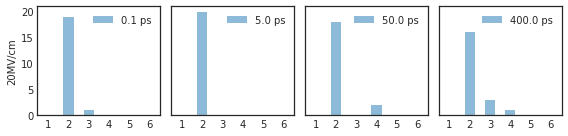

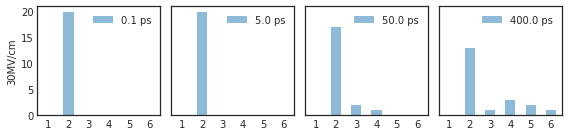

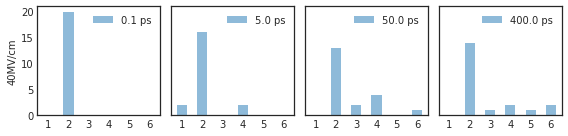

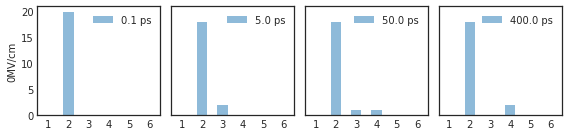

In [37]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 4, figsize=(8, 2), sharey=True)

    for s, ax in zip(steps_to_analyse, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(s - step_1))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        
        sns.distplot(coordination, kde=False,
                     bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
                     hist_kws={'alpha': 0.5, 'align': 'mid', 'rwidth': 0.5},
                     ax=ax, label = '{:.1f} ps'.format((s-step_1)*dump_period/10000))
        ax.legend()
    
        ax.set_xticks(range(1, 7))
#         ax.set_yscale('log')
    ax_arr[0].set_ylabel("{}".format(name))
    f.tight_layout()
#     f.savefig('fe_aq_small_fe_coordination_{}.eps'.format(name.replace('/', '')), dpi=400, bbox_inches="tight")
plt.show()

## Kinetics Tracking

### Oxygen

In [15]:
O_first_layer_molecule_df_list = []
for cl, name, pos_z in zip(sim_list['connectivity_list'], sim_list['names'], sim_list['positions_z']):

    O_index_close_by = list(O_index[pos_z[-1][O_index-1] < np.percentile(pos_z[-1][O_index-1], 10)])
#     O_index_close_by = np.unique(O_index_close_by)
    
    step_molecules = []
    print('*'*50)
    print(name)
    print('*'*50)
    
    for s in steps_to_read[::100]:      
        step_df = pd.read_hdf(cl, key = 'step{}'.format(s-step_1))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in O_index_close_by])
        molecule_collection = []
        for i in O_index_close_by:
            molecule =  sim_list['symbols'][step_df[step_df.atom_a==i].atom_b.to_numpy()-1]
            molecule = np.append(molecule, 'O')
            elements, subscripts = np.unique(molecule, return_counts=True)
            molecule_collection.append(''.join(["{}{}".format(a, b) if b > 1 else "{}".format(a) for (a, b)in zip(elements, subscripts)]))
        molecule_collection_unique = np.unique(np.array(molecule_collection), return_counts=True)
        molecule_dict = dict(zip(molecule_collection_unique[0], molecule_collection_unique[1]))
        step_molecules.append(molecule_dict)
    O_first_layer_molecule_df_list.append(pd.DataFrame(step_molecules, index=(steps_to_read[::100]-step_1)/100))

**************************************************
20MV/cm
**************************************************
**************************************************
30MV/cm
**************************************************
**************************************************
40MV/cm
**************************************************
**************************************************
0MV/cm
**************************************************


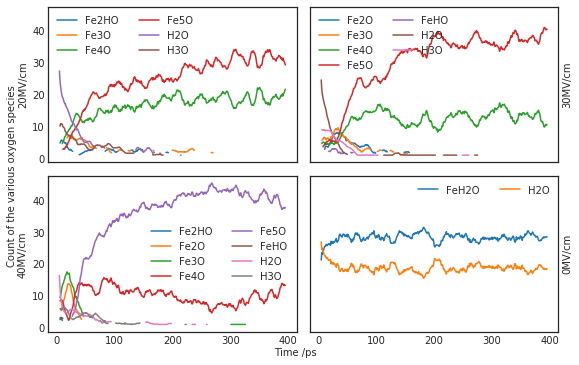

In [16]:
filter_count = 5
f, ax_arr = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)

for i, ax,name in zip(O_first_layer_molecule_df_list, ax_arr.ravel(), sim_list['names']):
    df = i.copy()
    df = df.loc[:, np.logical_and(df.max() > filter_count, df.max() < 400)]
    ax.plot(df.index, df.rolling(10, center=True).mean())
    ax.legend(df.columns, ncol=2)
    ax.set_ylabel("{}".format(name))
    if name.startswith('0') or name.startswith('3'):
        ax.yaxis.set_label_position("right")

f.text(0.5, 0.00, 'Time /ps', ha='center')
f.text(0.00, 0.5, 'Count of the various oxygen species', va='center', rotation='vertical')
f.tight_layout()
f.savefig('fe_aq_co2_small_long_overall_species_count.eps', dpi=400, bbox_inches="tight")
plt.show()

### Carbon

In [40]:
C_first_layer_molecule_df_list = []
for cl, name, pos_z in zip(sim_list['connectivity_list'], sim_list['names'], sim_list['positions_z']):
    
    step_molecules = []
    print('*'*50)
    print(name)
    print('*'*50)
    
    for s in steps_to_read[::100]:      
        step_df = pd.read_hdf(cl, key = 'step{}'.format(s-step_1))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index_close_by])
        molecule_collection = []
        for i in C_index:
            molecule =  sim_list['symbols'][step_df[step_df.atom_a==i].atom_b.to_numpy()-1]
            molecule = np.append(molecule, 'C')
            elements, subscripts = np.unique(molecule, return_counts=True)
            molecule_collection.append(''.join(["{}{}".format(a, b) if b > 1 else "{}".format(a) for (a, b)in zip(elements, subscripts)]))
        molecule_collection_unique = np.unique(np.array(molecule_collection), return_counts=True)
        molecule_dict = dict(zip(molecule_collection_unique[0], molecule_collection_unique[1]))
        step_molecules.append(molecule_dict)
    C_first_layer_molecule_df_list.append(pd.DataFrame(step_molecules, index=(steps_to_read[::100]-step_1)/100))

**************************************************
20MV/cm
**************************************************
**************************************************
30MV/cm
**************************************************
**************************************************
40MV/cm
**************************************************
**************************************************
0MV/cm
**************************************************


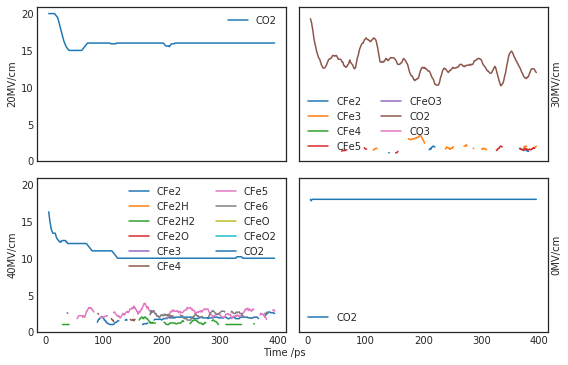

In [43]:
filter_count = 2
f, ax_arr = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)

for i, ax,name in zip(C_first_layer_molecule_df_list, ax_arr.ravel(), sim_list['names']):
    df = i.copy()
    df = df.loc[:, np.logical_and(df.max() > filter_count, df.max() < 400)]
    ax.plot(df.index, df.rolling(10, center=True).mean())
    ax.legend(df.columns, ncol=2)
    ax.set_ylabel("{}".format(name))
    if name.startswith('0') or name.startswith('3'):
        ax.yaxis.set_label_position("right")

f.text(0.5, 0.00, 'Time /ps', ha='center')
f.tight_layout()
# f.savefig('fe_aq_co2_small_long_overall_species_count.eps', dpi=400, bbox_inches="tight")
plt.show()

## Tracking Individual Molecules

## Molecule Count

In [41]:
import networkx as nx
from ase.data.colors import jmol_colors
from ase.data import atomic_numbers

for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    step_molecules = []
    print('*'*50)
    print(name)
    print('*'*50)
    
    for s in steps_to_analyse:
        step_df = pd.read_hdf(cl, key = 'step{}'.format(s-step_1))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in Fe_index])
        G = nx.from_pandas_edgelist(step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
        molecule_collection = []
        for i in Fe_index[coordination>1]:
            for G_subset in nx.connected_components(G):
                if i in G_subset:
                    molecule =  sim_list['symbols'][np.array(list(G_subset))-1]
                    elements, subscripts = np.unique(molecule, return_counts=True)
                    molecule_collection.append(''.join(["{}{}".format(a, b) if b > 1 else "{}".format(a) for (a, b)in zip(elements, subscripts)]))
        molecule_collection_unique = np.unique(np.array(molecule_collection), return_counts=True)
        molecule_dict = dict(zip(molecule_collection_unique[0], molecule_collection_unique[1]))
        step_molecules.append(molecule_dict)
    print(pd.DataFrame(step_molecules, index=steps_to_analyse))

**************************************************
20MV/cm
**************************************************
       C2Fe6H18O5  C3Fe1957H341O256  CFe1960H18O11  CFeH3O3  CFeH9O4  \
15            NaN               NaN         1960.0      NaN      NaN   
505           NaN               NaN            NaN      NaN      NaN   
5005          6.0               NaN            NaN      1.0      1.0   
40005         NaN            1957.0            NaN      NaN      NaN   

       Fe1940H108O145  Fe1960H37O48  Fe2H11O4  Fe3H12O3  FeH4O2  FeH6O3  
15                NaN           NaN       NaN       NaN     NaN     NaN  
505               NaN        1960.0       NaN       NaN     NaN     NaN  
5005           1940.0           NaN       2.0       3.0     3.0     4.0  
40005             NaN           NaN       NaN       NaN     3.0     NaN  
**************************************************
30MV/cm
**************************************************
       C6Fe1959H227O213  C8Fe1959H335O263  CFe196